<h1>Arya Kashikar</h1>
<h2>PRN: 22070521036</h2>
<h2>Sem: 7 , Sec: A</h2>


<h1>Heart Disease Prediction</h1>
<h5>The primary goal is to build a predictive machine learning model with high recall for class 1 (patients with heart disease) to ensure we do not miss diagnosing a patient at risk.</h5>

<h2>Import Libraries</h2>

In [122]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [123]:
# Set the resolution of the plotted figures
plt.rcParams['figure.dpi'] = 200

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

<h2>Read Dataset</h2>

In [67]:
# Read dataset
df = pd.read_csv(r"C:\Users\91971\Downloads\heart (1).csv")
df 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


<h2>Dataset Overview</h2>

In [68]:
# Display a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [69]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [70]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [71]:
# Get the summary statistics for categorical variables
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


<h2>EDA</h2>

<h2>Univariate Analysis</h2>

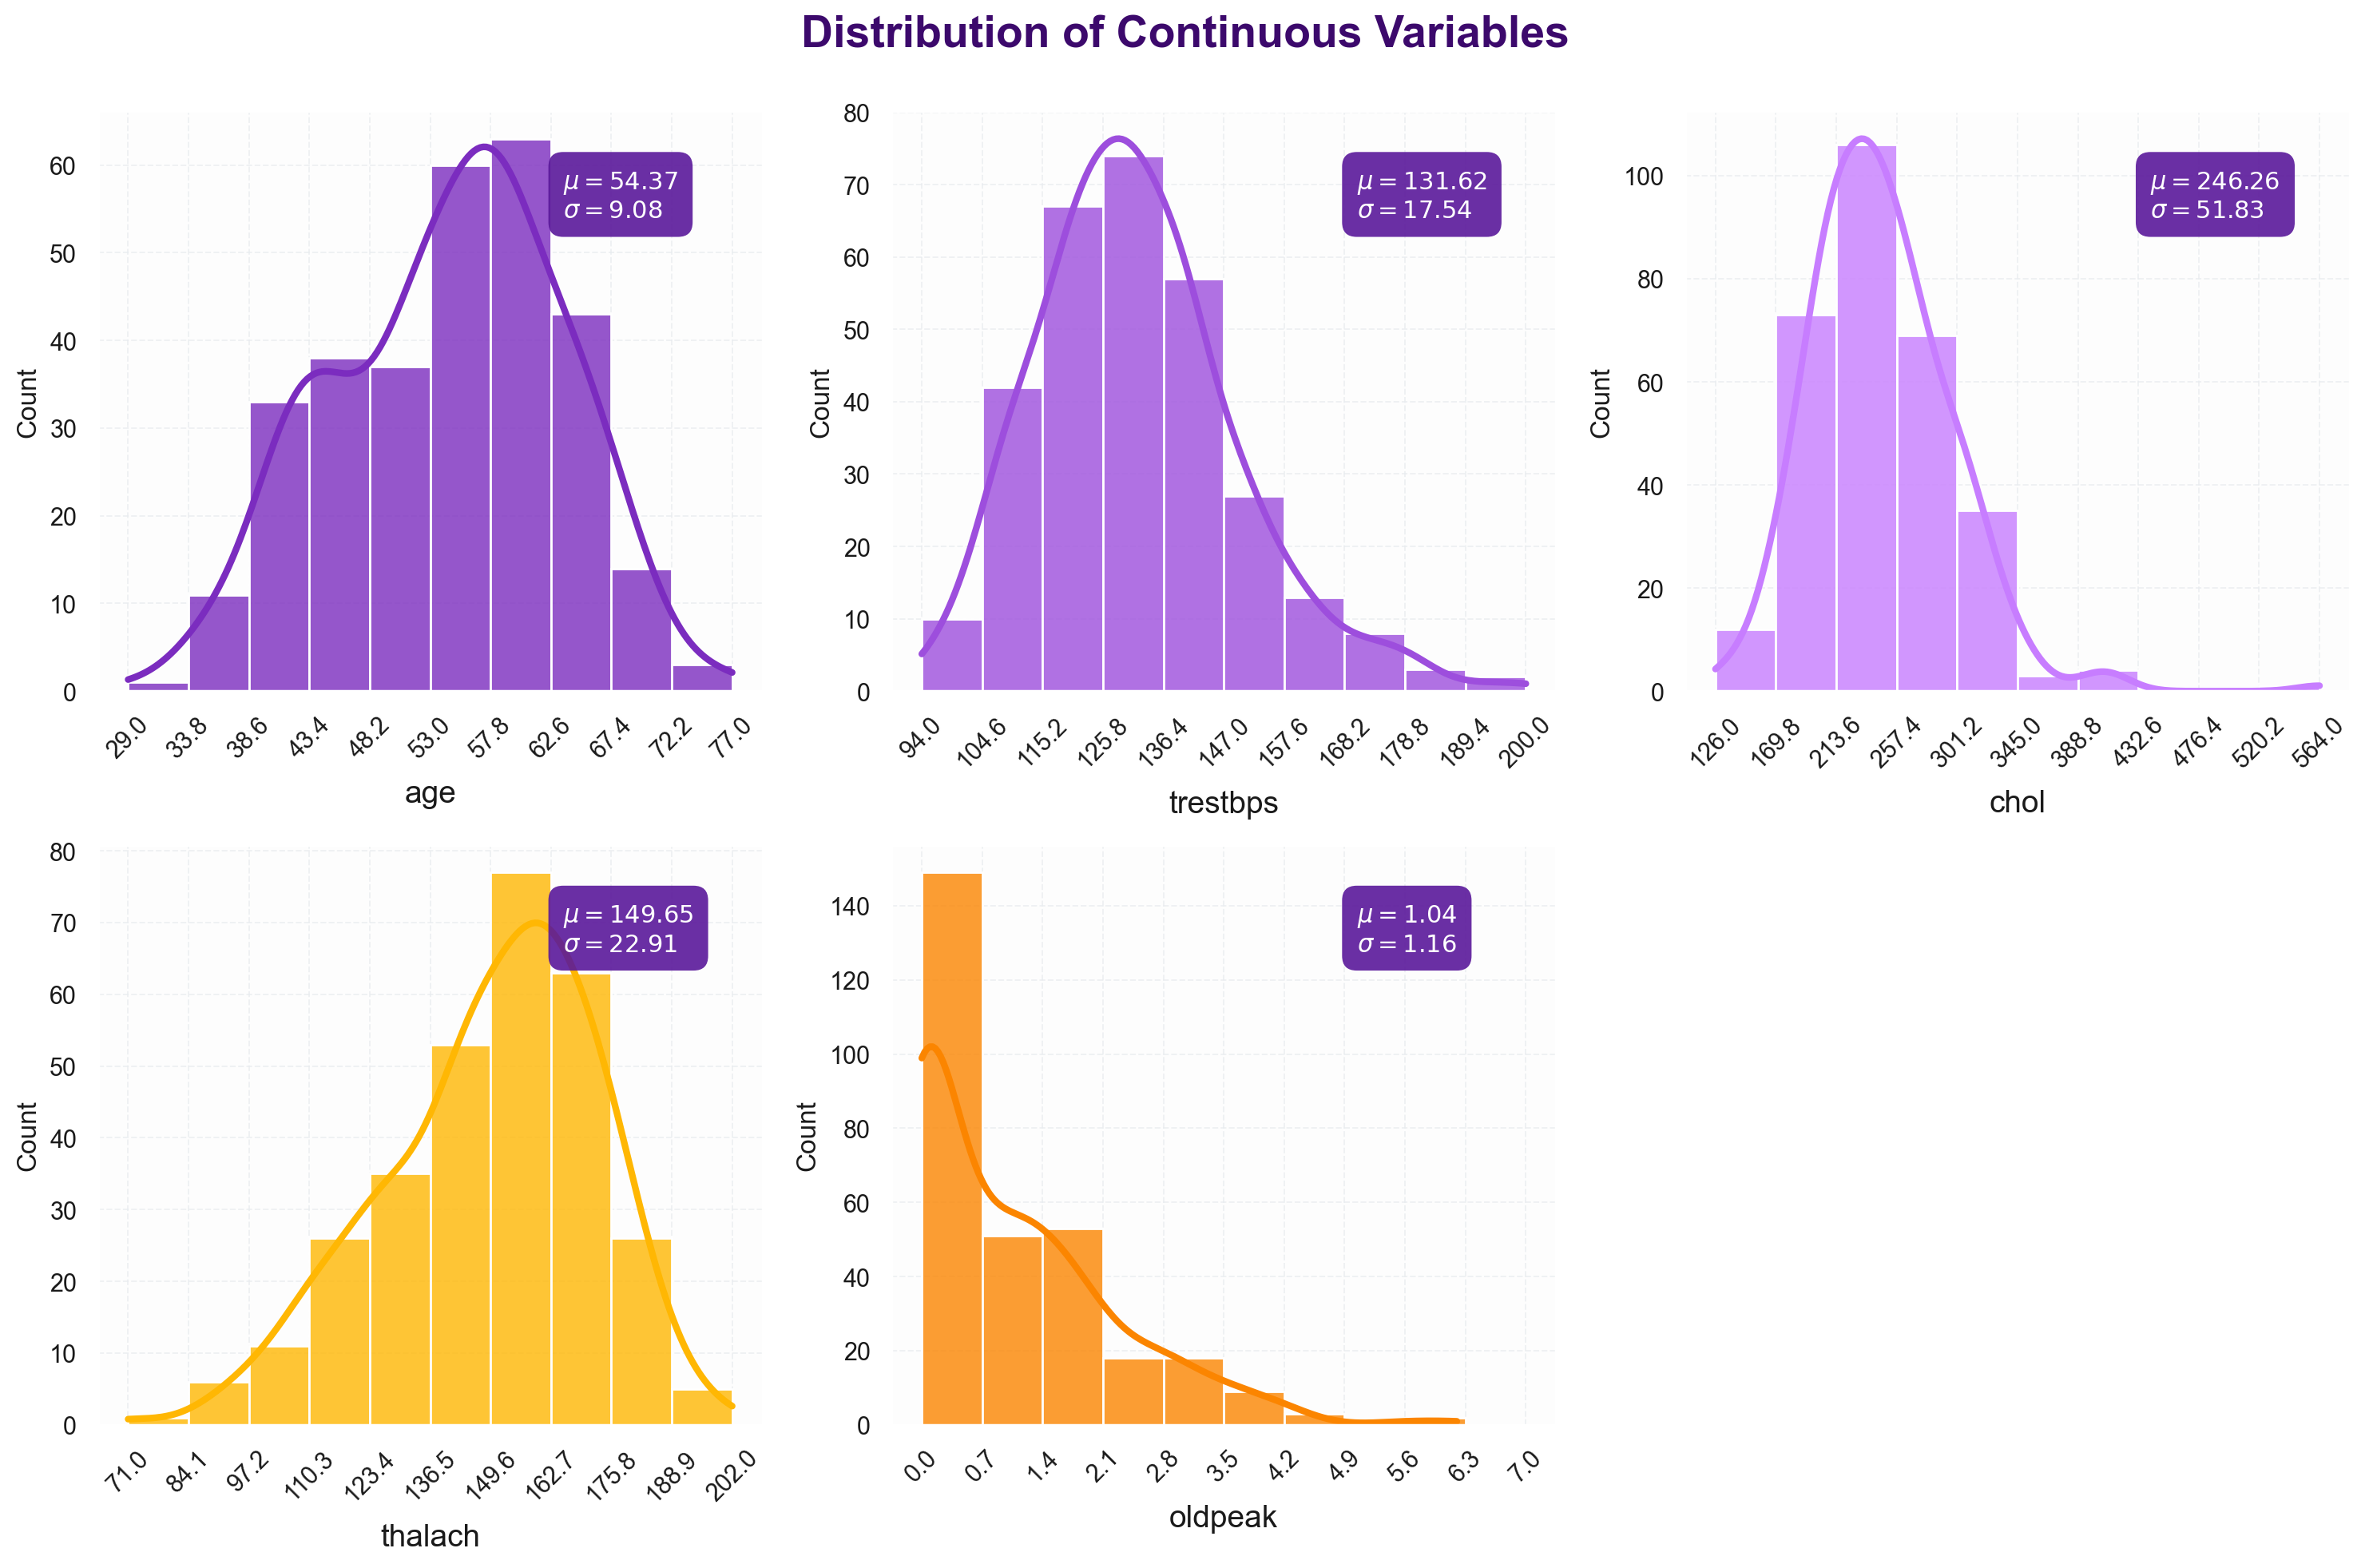

In [73]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Elegant deep–warm palette
colors = ['#7b2cbf', '#9d4edd', '#c77dff', '#ffb703', '#fb8500', '#f9844a']

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(
        df_continuous[col],
        range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max()))
    )
    
    graph = sns.histplot(
        data=df_continuous,
        x=col,
        bins=bin_edges,
        kde=True,
        ax=ax[x, y],
        edgecolor='white',
        color=colors[i % len(colors)],
        alpha=0.8,
        line_kws={'lw': 3, 'color': '#3c096c'}
    )
    
    # Axis labels & formatting
    ax[x, y].set_xlabel(col, fontsize=14, color='#1a1a1a', labelpad=8)
    ax[x, y].set_ylabel('Count', fontsize=12, color='#1a1a1a')
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45, color='#1a1a1a')
    ax[x, y].tick_params(axis='y', colors='#1a1a1a')
    
    # Grid & background
    ax[x, y].grid(color='#e9ecef', linestyle='--', linewidth=0.7, alpha=0.7)
    ax[x, y].set_facecolor('#fdfdfd')
    
    # Mean and Std box
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(
        0.70, 0.9, textstr,
        transform=ax[x, y].transAxes,
        fontsize=11,
        verticalalignment='top',
        color='#ffffff',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='#5a189a', edgecolor='none', alpha=0.9)
    )

# Hide last empty subplot if any
ax[1, 2].axis('off')

plt.suptitle(
    'Distribution of Continuous Variables',
    fontsize=20,
    color='#3c096c',
    fontweight='bold'
)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [74]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

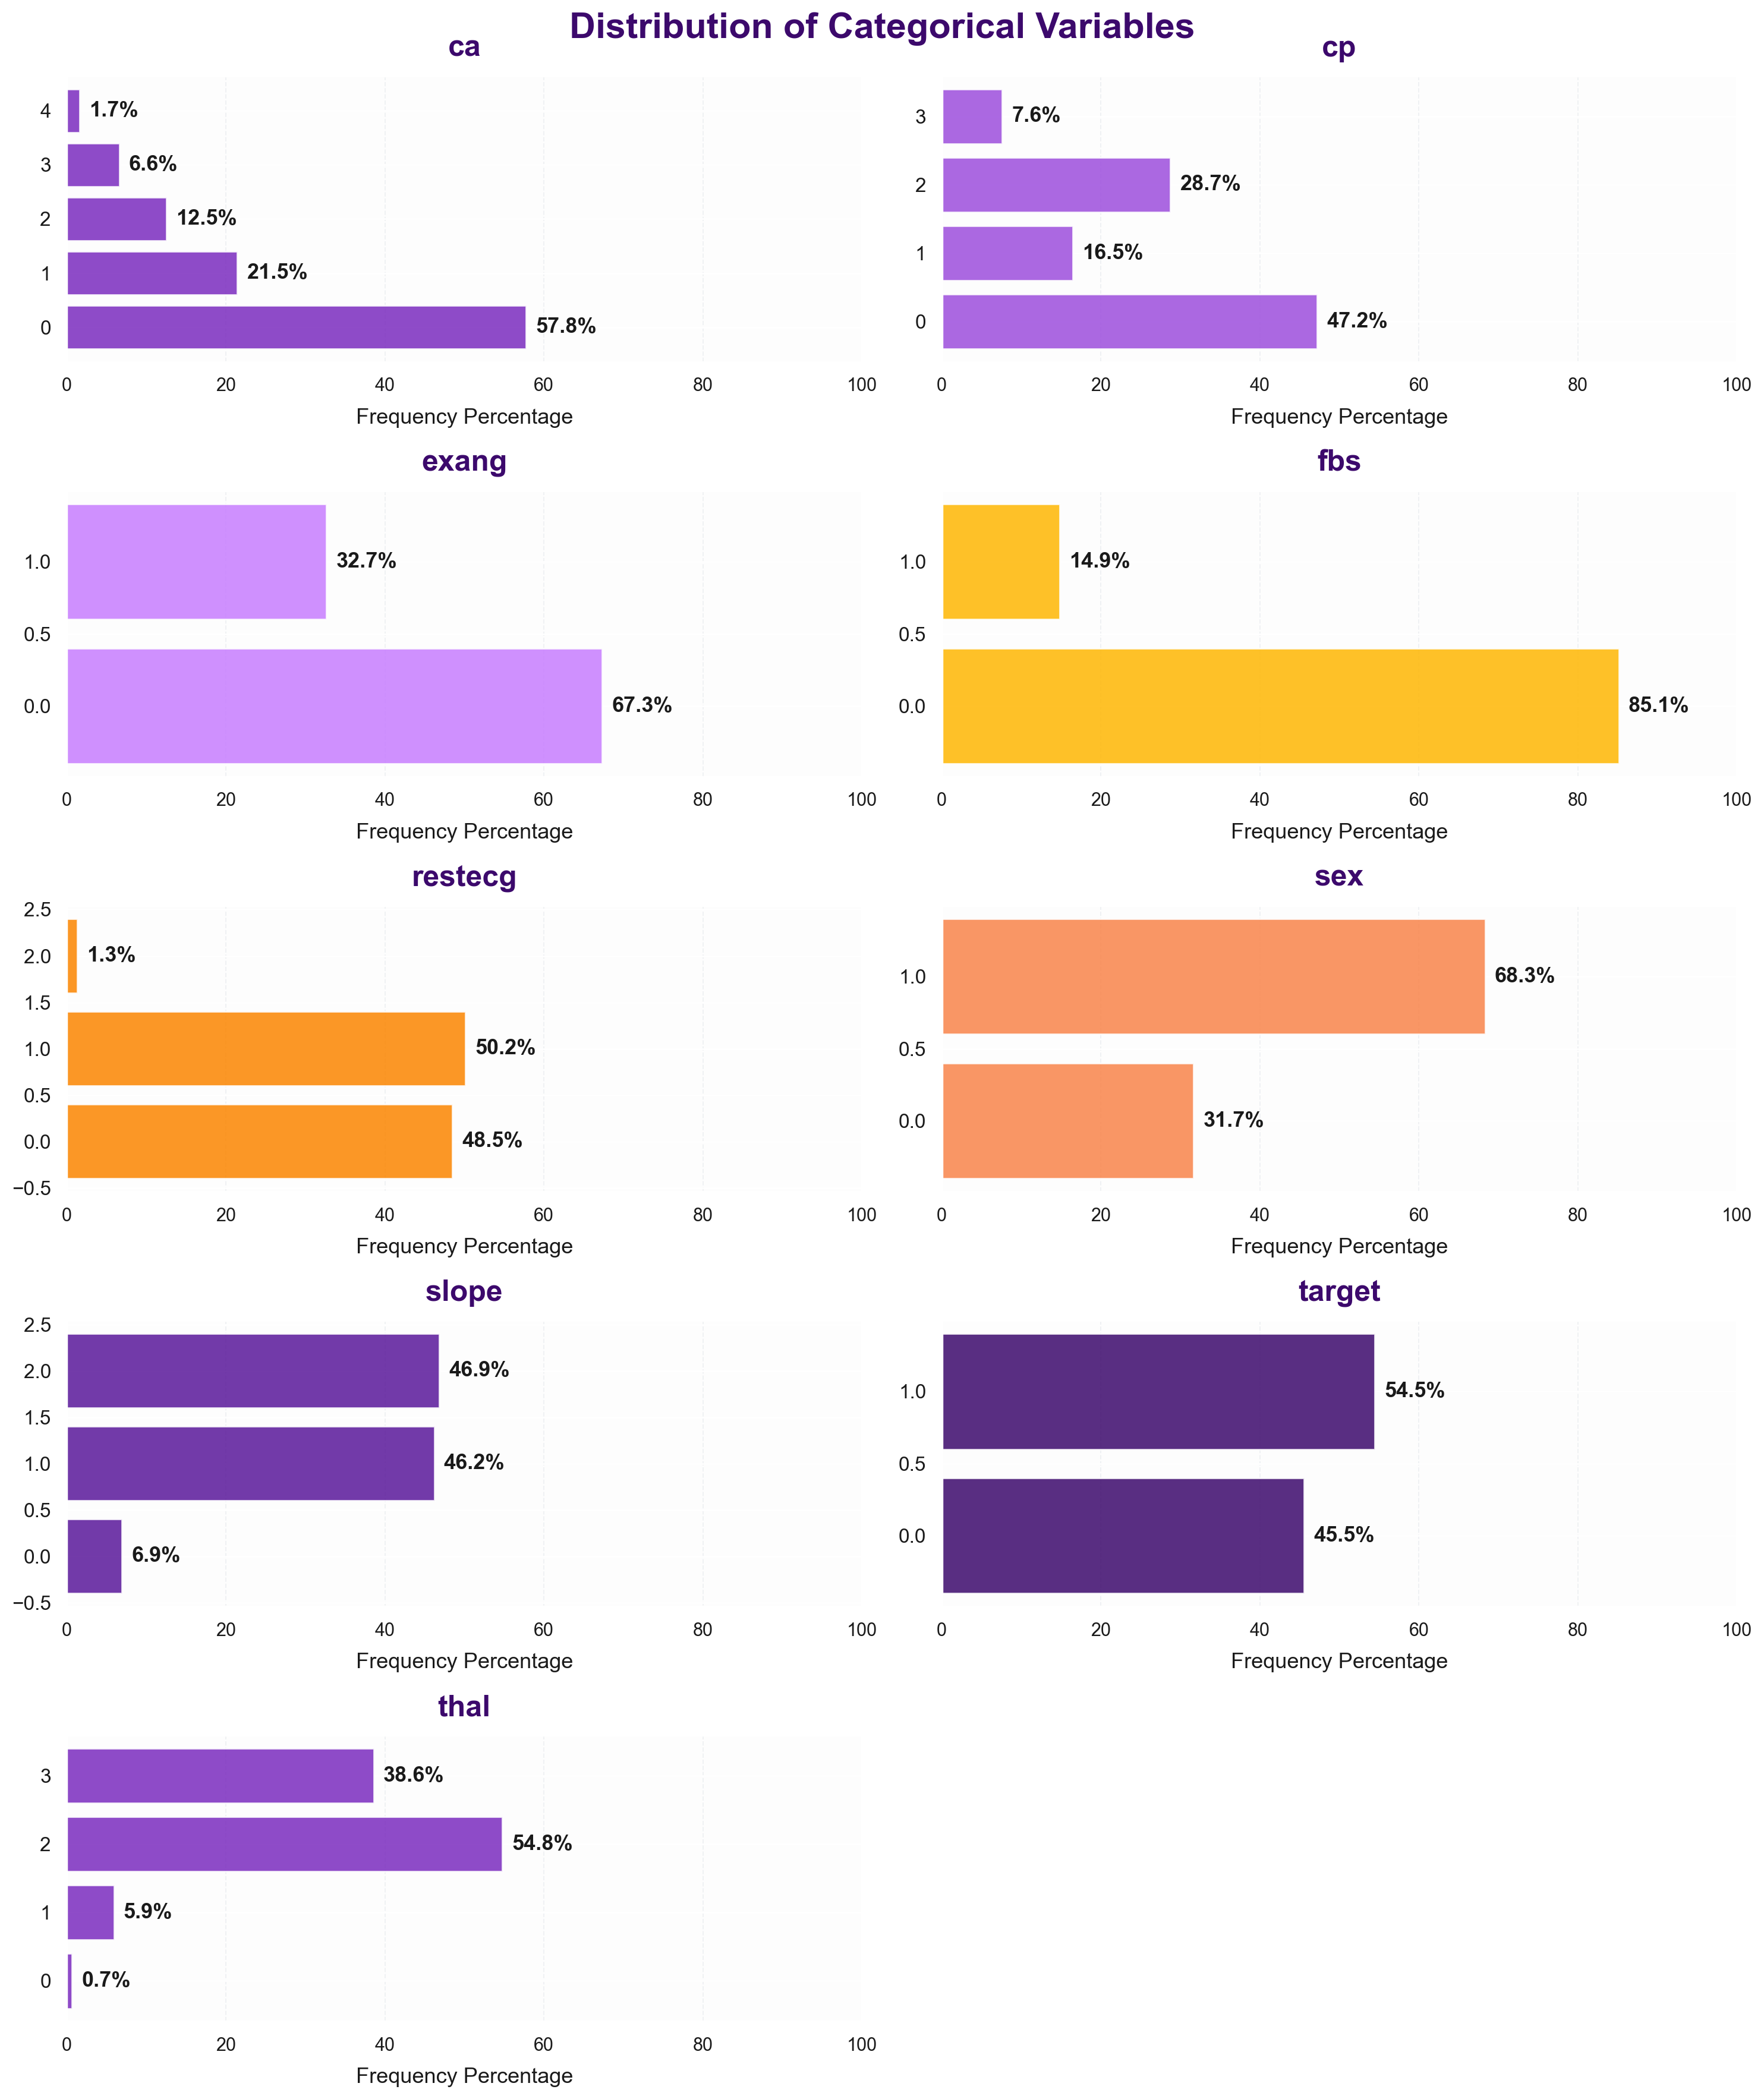

In [76]:
# Set up the subplot for a 5x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Define color palette (deep violet–amber theme)
bar_colors = ['#7b2cbf', '#9d4edd', '#c77dff', '#ffb703', '#fb8500', '#f9844a', '#5a189a', '#3c096c']

# Loop through categorical features
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values(ascending=True)
    
    # Choose color dynamically for variety
    color = bar_colors[i % len(bar_colors)]
    
    # Plot horizontal bar chart
    bars = ax[row, col_idx].barh(value_counts.index, value_counts.values, color=color, alpha=0.85, edgecolor='white')
    
    # Annotate percentage values
    for bar in bars:
        width = bar.get_width()
        ax[row, col_idx].text(
            width + 1.2, bar.get_y() + bar.get_height() / 2,
            f'{width:.1f}%',
            va='center', fontsize=13, fontweight='bold', color='#1a1a1a'
        )
    
    # Axis formatting
    ax[row, col_idx].set_xlim([0, 100])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=13, color='#1a1a1a', labelpad=8)
    ax[row, col_idx].set_title(f'{col}', fontsize=18, color='#3c096c', fontweight='bold', pad=12)
    ax[row, col_idx].set_facecolor('#fdfdfd')
    ax[row, col_idx].grid(axis='x', color='#e9ecef', linestyle='--', linewidth=0.7, alpha=0.7)
    ax[row, col_idx].tick_params(axis='y', labelcolor='#1a1a1a', labelsize=12)
    ax[row, col_idx].tick_params(axis='x', labelcolor='#1a1a1a')
    
# Hide last empty subplot if the number of features is odd
if len(categorical_features) % 2 != 0:
    ax[4, 1].axis('off')

plt.suptitle(
    'Distribution of Categorical Variables',
    fontsize=22,
    color='#3c096c',
    fontweight='bold'
)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


<h2>Bivariate Analysis</h2>

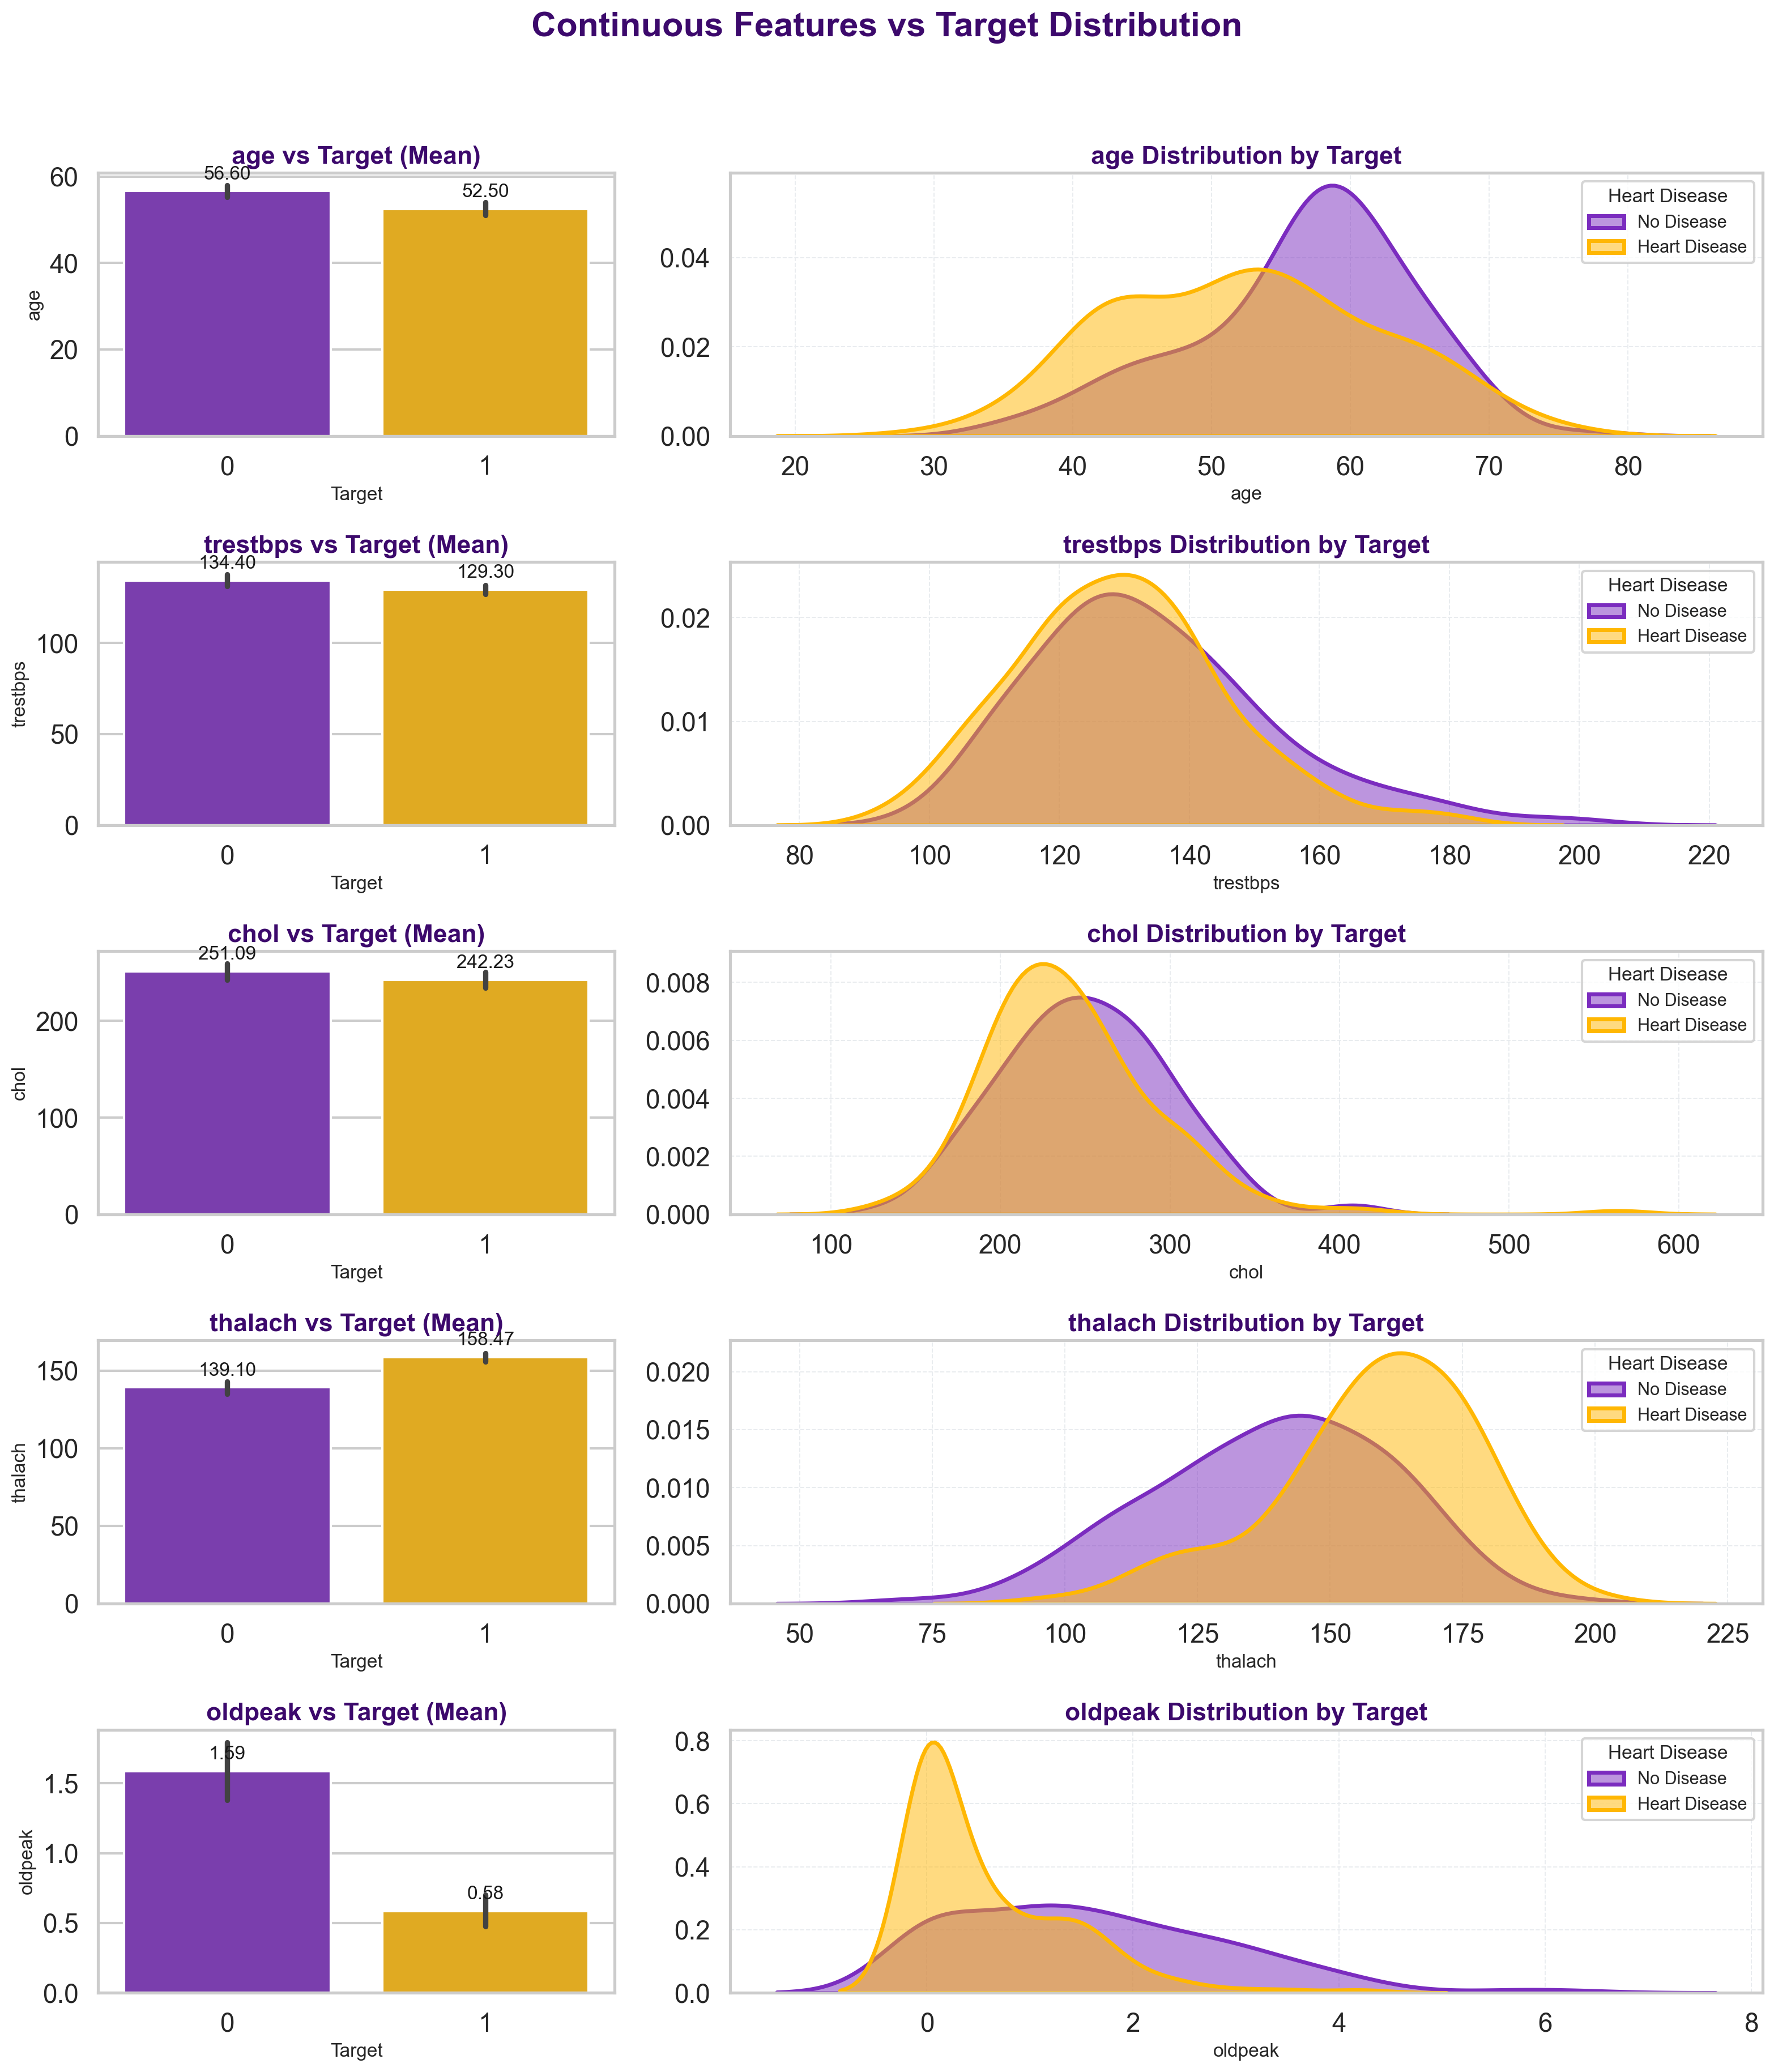

In [77]:

# Elegant Bivariate Analysis
# Set custom Seaborn theme
sns.set_style("whitegrid")
sns.set_context("talk")

# Define color palette
colors = {
    0: '#7b2cbf',   # Violet for No Heart Disease
    1: '#ffb703'    # Amber for Heart Disease
}

# Create subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(16, 18), 
                       gridspec_kw={'width_ratios': [1, 2]})

# Loop through continuous features
for i, col in enumerate(continuous_features):
    
    # Barplot: mean value of each feature for target categories
    bar = sns.barplot(
        data=df, x="target", y=col, 
        palette=[colors[0], colors[1]],
        edgecolor='white', ax=ax[i, 0]
    )
    
    # Annotate bars with mean values
    for container in bar.containers:
        bar.bar_label(container, fmt='%.2f', fontsize=12, label_type='edge', padding=5, color='#1a1a1a')
    
    # KDE plot: distribution of feature for both target classes
    sns.kdeplot(
        data=df[df["target"] == 0], x=col, fill=True, 
        alpha=0.5, linewidth=2.5, color=colors[0], ax=ax[i, 1], label='No Disease'
    )
    sns.kdeplot(
        data=df[df["target"] == 1], x=col, fill=True, 
        alpha=0.5, linewidth=2.5, color=colors[1], ax=ax[i, 1], label='Heart Disease'
    )
    
    # Customize axes
    ax[i, 0].set_title(f'{col} vs Target (Mean)', fontsize=16, color='#3c096c', fontweight='bold')
    ax[i, 1].set_title(f'{col} Distribution by Target', fontsize=16, color='#3c096c', fontweight='bold')
    
    ax[i, 0].set_xlabel('Target', fontsize=12)
    ax[i, 0].set_ylabel(col, fontsize=12)
    
    ax[i, 1].set_xlabel(col, fontsize=12)
    ax[i, 1].set_ylabel('')
    ax[i, 1].grid(color='#e9ecef', linestyle='--', linewidth=0.7)
    ax[i, 1].legend(title='Heart Disease', loc='upper right', fontsize=11, title_fontsize=12)
    
# Adjust layout
plt.suptitle(
    'Continuous Features vs Target Distribution',
    fontsize=22, fontweight='bold', color='#3c096c', y=1.02
)
plt.tight_layout()
plt.show()


In [78]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

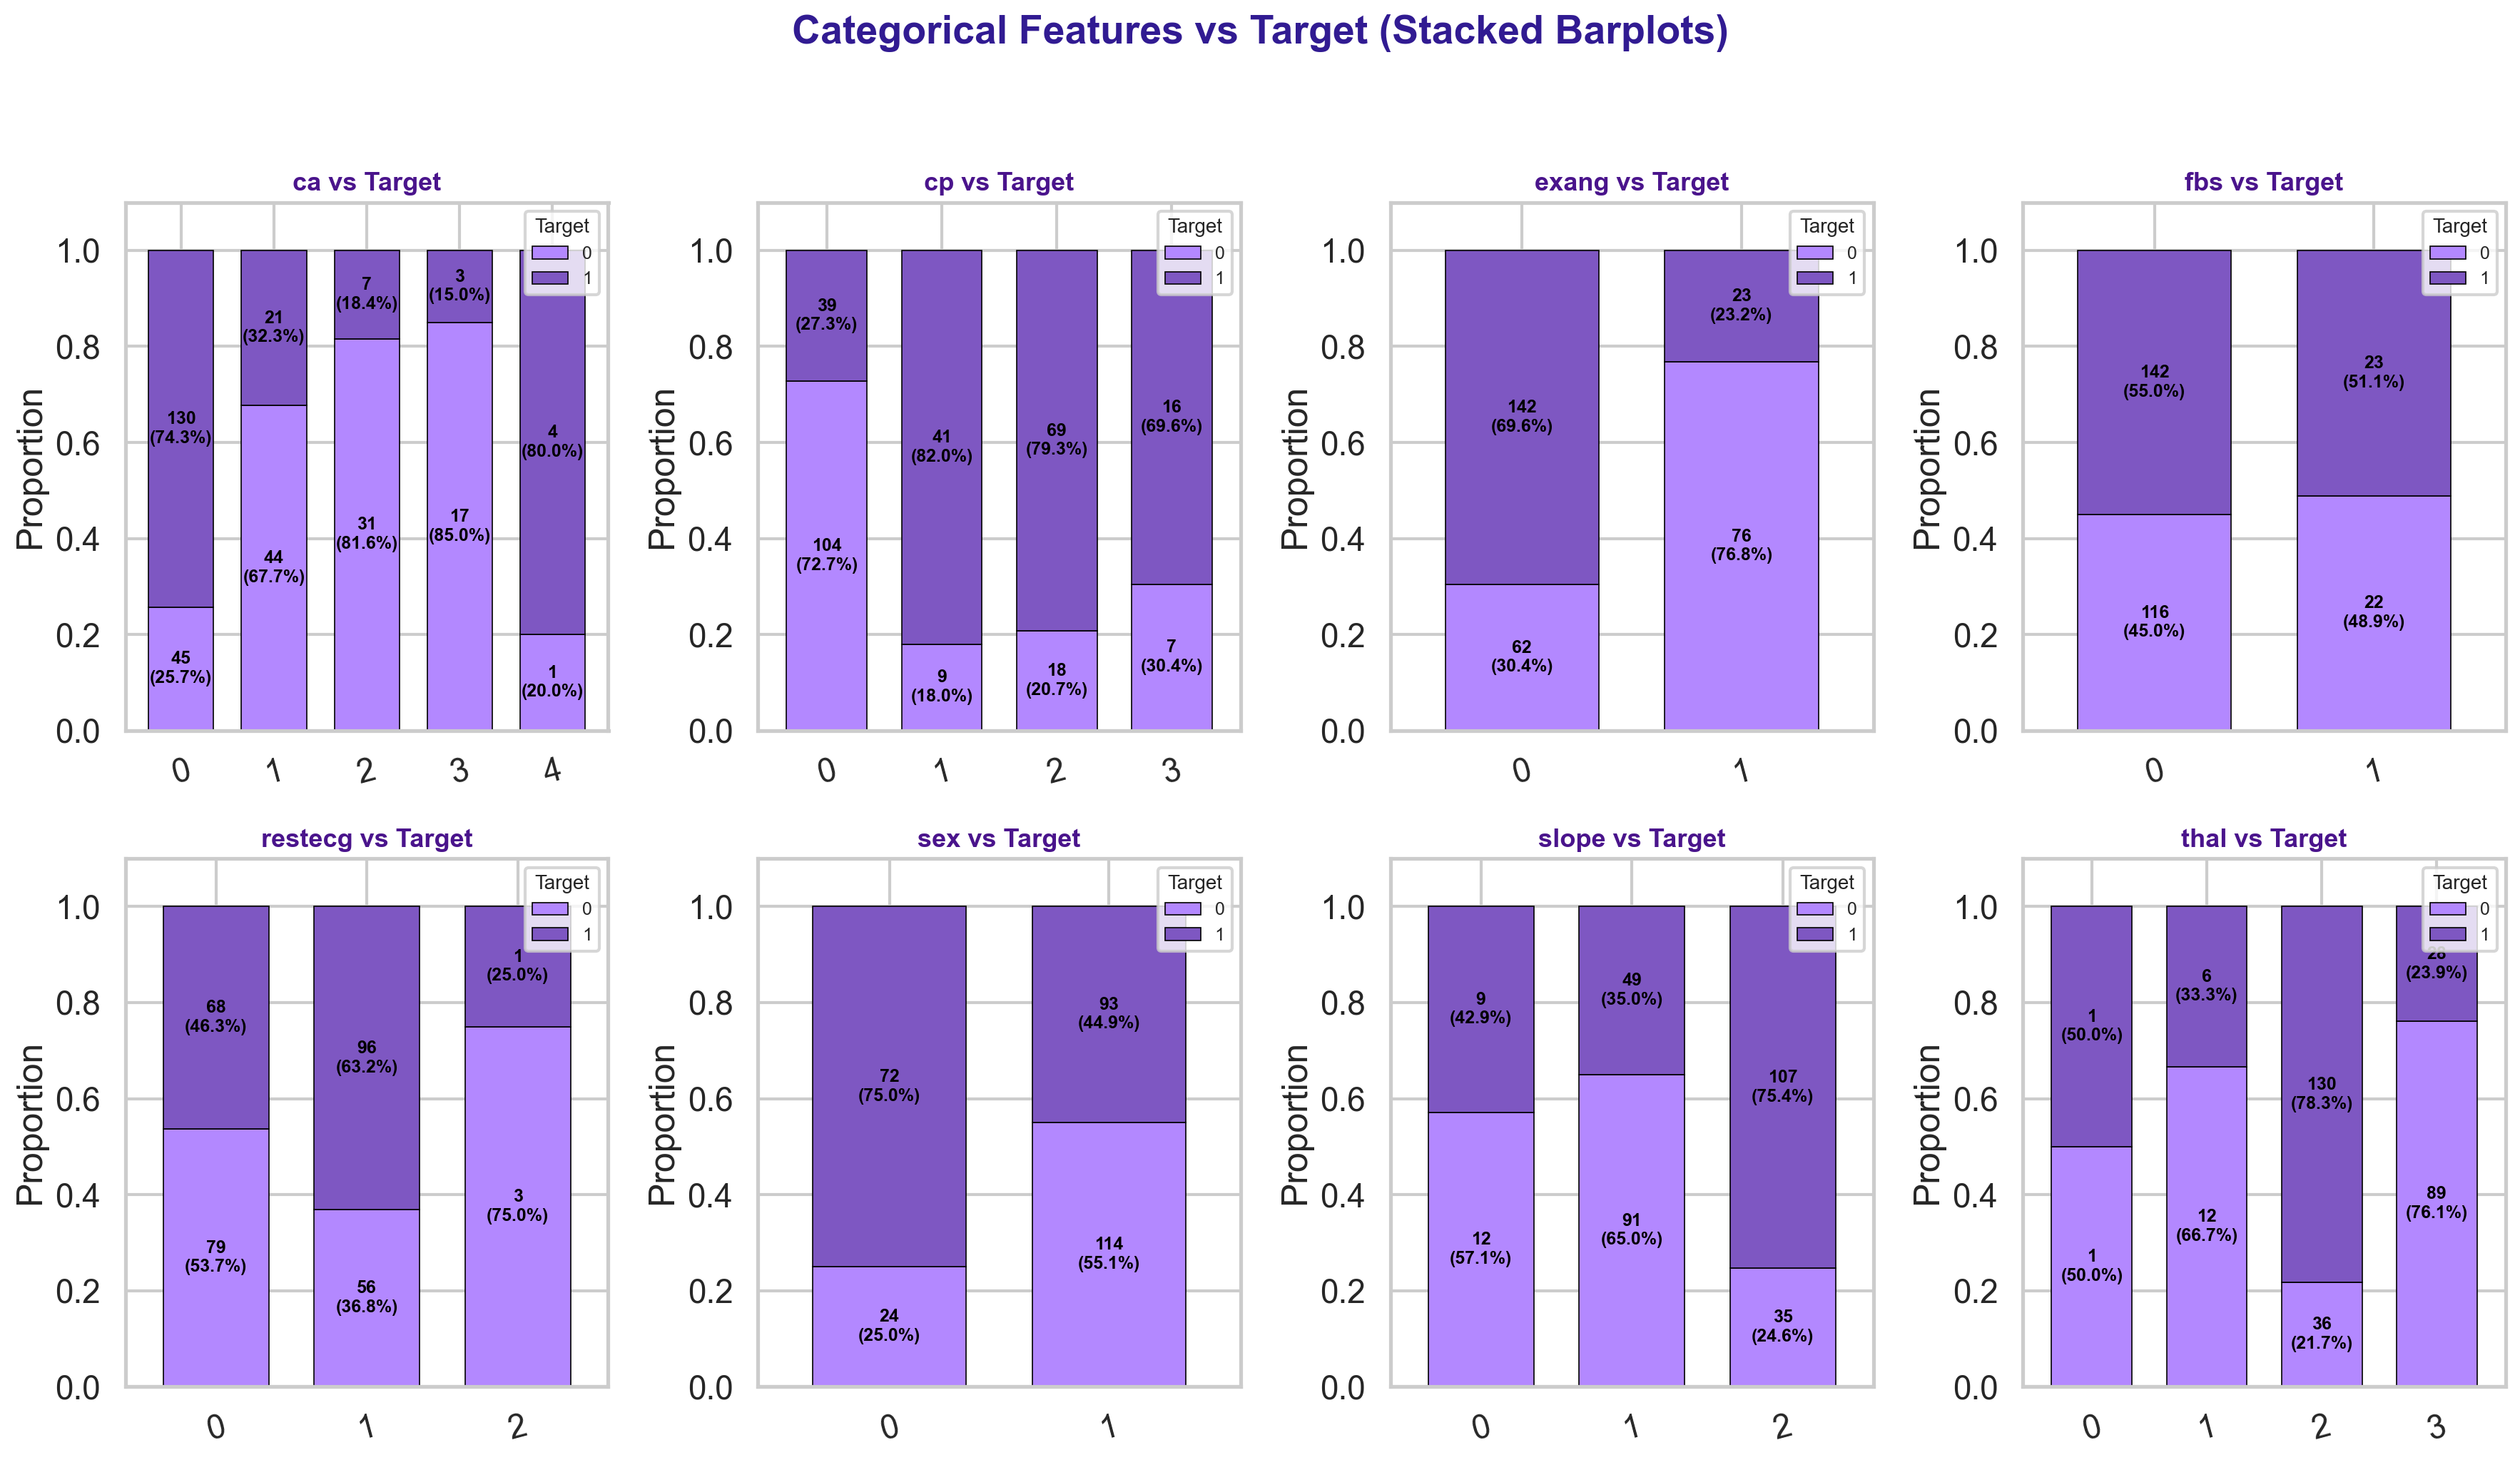

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

# Violet palette (light → dark)
cmp = ListedColormap(['#b388ff', '#7e57c2'])  
sns.set_style("whitegrid")

# Create figure and axes grid
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
axes = ax.flatten()

for i, col in enumerate(categorical_features):
    # Cross-tab for count and proportion
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Stacked barplot with violet theme
    cross_tab_prop.plot(kind='bar',
                        ax=axes[i],
                        stacked=True,
                        width=0.7,
                        colormap=cmp,
                        edgecolor='black',
                        linewidth=0.6,
                        legend=False)

    # Add count and percentage annotations
    for idx, cat in enumerate(cross_tab.index):
        cumulative = 0
        for j, target_val in enumerate(cross_tab.columns):
            proportion = cross_tab_prop.loc[cat, target_val]
            count = cross_tab.loc[cat, target_val]
            axes[i].text(idx, cumulative + proportion/2,
                         f'{count}\n({proportion*100:.1f}%)',
                         ha='center', va='center',
                         fontsize=9, fontweight='bold', color='black')
            cumulative += proportion

    # Titles and formatting
    axes[i].set_title(f"{col} vs Target", fontsize=13, fontweight='bold', color='#4a148c')
    axes[i].set_ylim(0, 1.1)
    axes[i].set_ylabel("Proportion")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].legend(title='Target', loc='upper right', fontsize=9, title_fontsize=10)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global figure title
plt.suptitle("Categorical Features vs Target (Stacked Barplots)", fontsize=20, fontweight='bold', color='#311b92', y=1.03)
plt.tight_layout()
plt.show()


<h2>Data Preprocessing</h2>

In [81]:
# Check for missing values in the dataset
df.isnull().sum().sum()

0

In [82]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [83]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

In [84]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [85]:
# Displaying the resulting DataFrame after one-hot encoding
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


In [86]:
# Define the features (X) and the output labels (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [87]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [88]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [89]:
# Adding a small constant to 'oldpeak' to make all values positive
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

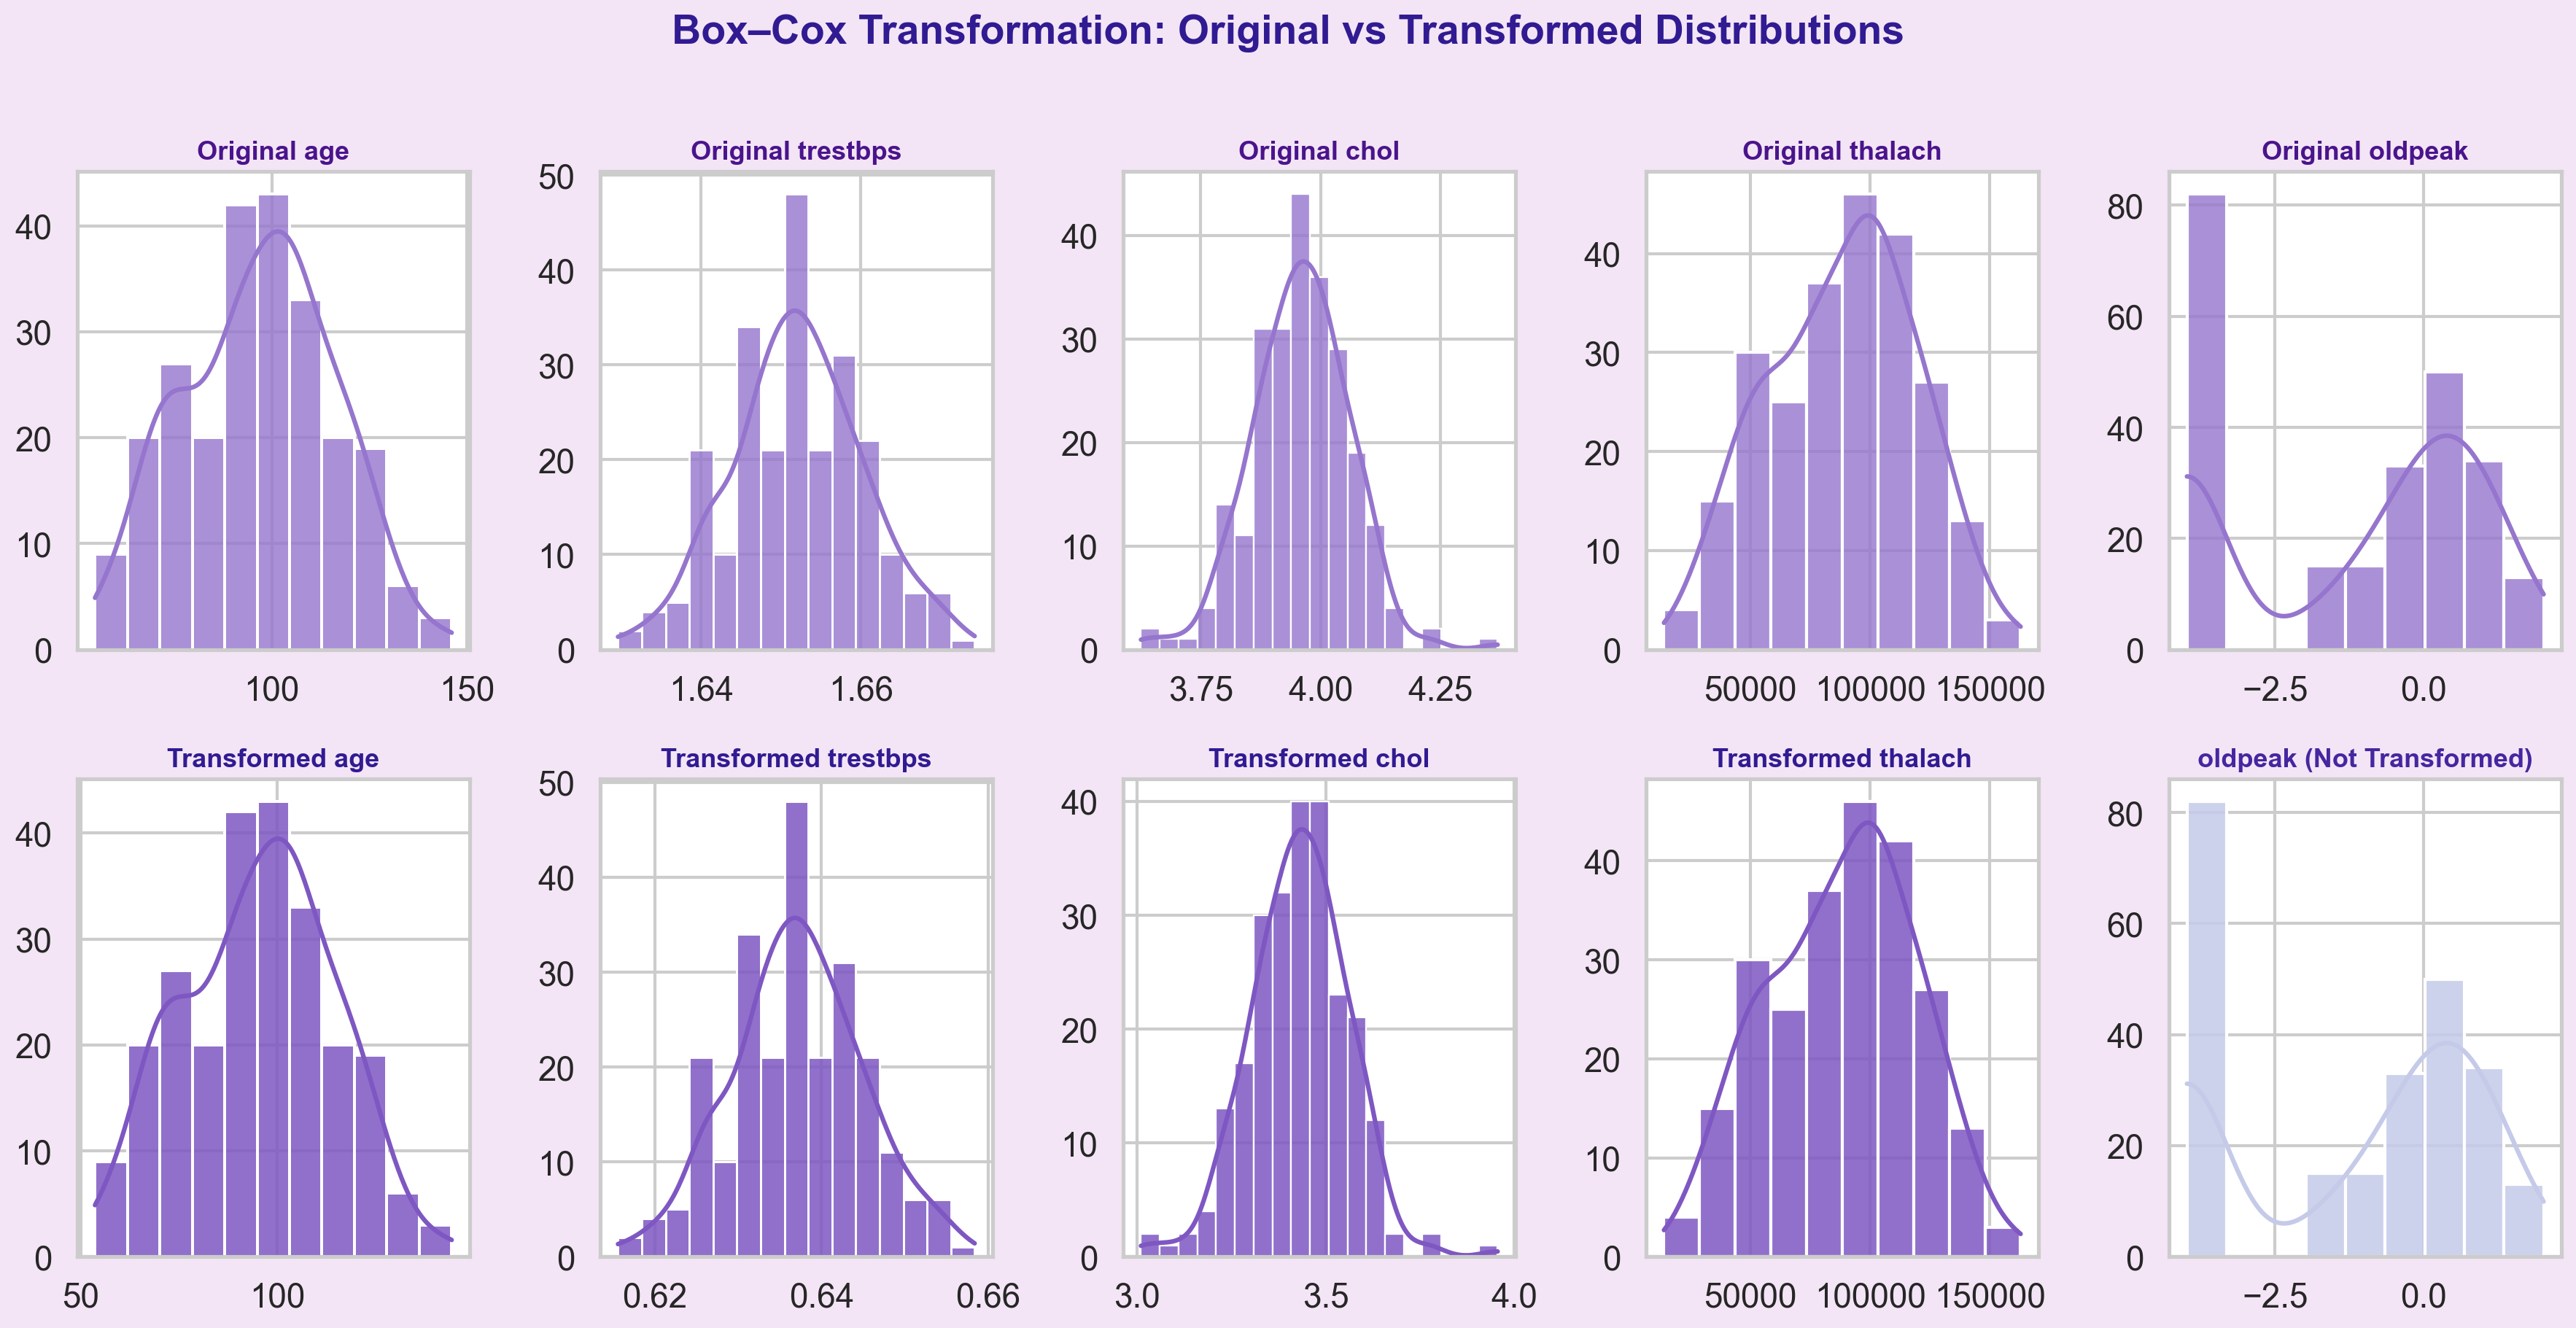

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox

# Set theme
sns.set_style("whitegrid")
sns.set_palette("Purples")

# Create subplots
fig, ax = plt.subplots(2, 5, figsize=(18, 9))

# For lambda values storage
lambdas = {}

# Plot original distributions (top row)
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0, i],
                 color='#9575cd', edgecolor='white', alpha=0.8)
    ax[0, i].set_title(f'Original {col}', fontsize=13, fontweight='bold', color='#4a148c')
    ax[0, i].set_xlabel('')
    ax[0, i].set_ylabel('')

# Apply Box–Cox Transformation & Plot (bottom row)
for i, col in enumerate(continuous_features):
    if X_train[col].min() > 0:
        # Apply Box-Cox
        X_train[col], lambdas[col] = boxcox(X_train[col])
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])
        sns.histplot(X_train[col], kde=True, ax=ax[1, i],
                     color='#7e57c2', edgecolor='white', alpha=0.85)
        ax[1, i].set_title(f'Transformed {col}', fontsize=13, fontweight='bold', color='#311b92')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1, i],
                     color='#c5cae9', edgecolor='white', alpha=0.85)
        ax[1, i].set_title(f'{col} (Not Transformed)', fontsize=13, fontweight='bold', color='#4527a0')
    
    ax[1, i].set_xlabel('')
    ax[1, i].set_ylabel('')

# Add global titles
fig.suptitle('Box–Cox Transformation: Original vs Transformed Distributions',
             fontsize=20, fontweight='bold', color='#311b92', y=1.02)

# Adjust layout and background
fig.patch.set_facecolor('#f3e5f5')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [91]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,99.775363,1,1.652121,4.044511,1,34193.227632,1,0.490856,0,0,False,False,False,False,False,False,False,True
191,104.060287,1,1.651135,3.909224,0,61564.640490,1,0.846853,1,3,False,False,False,False,False,False,False,True
15,87.096593,0,1.646937,3.916243,0,97354.894861,0,0.490856,1,0,False,True,False,True,False,False,True,False
224,95.519188,1,1.641028,3.960431,0,55975.891019,1,1.130195,1,1,False,False,False,True,False,False,False,True
250,89.190732,1,1.656716,4.069855,0,51729.486474,1,1.634849,1,3,False,False,False,True,False,False,False,True


<h2>Decision Tree Model Building</h2>

In [92]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

In [93]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest recall for class 1 is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [94]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [95]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [96]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [97]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [98]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [99]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    # Convert dictionary to dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

In [100]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.8,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79


<h2>Random Forest Model Building</h2>

In [102]:
rf_base = RandomForestClassifier(random_state=0)

In [103]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [104]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


In [105]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.83      0.87      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [106]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [107]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84


<h2>KNN Model Building</h2>

In [108]:
# Define the base KNN model and set up the pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [109]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [110]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}


In [111]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       110
           1       0.83      0.83      0.83       132

    accuracy                           0.81       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.81      0.81      0.81       242



In [112]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [113]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


<h2>SVM Model Building</h2>

In [114]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

In [115]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [116]:
# Call the function for hyperparameter tuning
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


In [117]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.54      0.68       110
           1       0.71      0.96      0.82       132

    accuracy                           0.77       242
   macro avg       0.82      0.75      0.75       242
weighted avg       0.81      0.77      0.76       242



In [118]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.94,0.73,0.57,0.97,0.71,0.83,0.83,0.77,0.77,0.79


<h2>Conclusion</h2>

In [119]:
# Concatenate the dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'recall_1'
results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.94,0.73,0.57,0.97,0.71,0.83,0.83,0.77,0.77,0.79
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84
DT,0.80,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


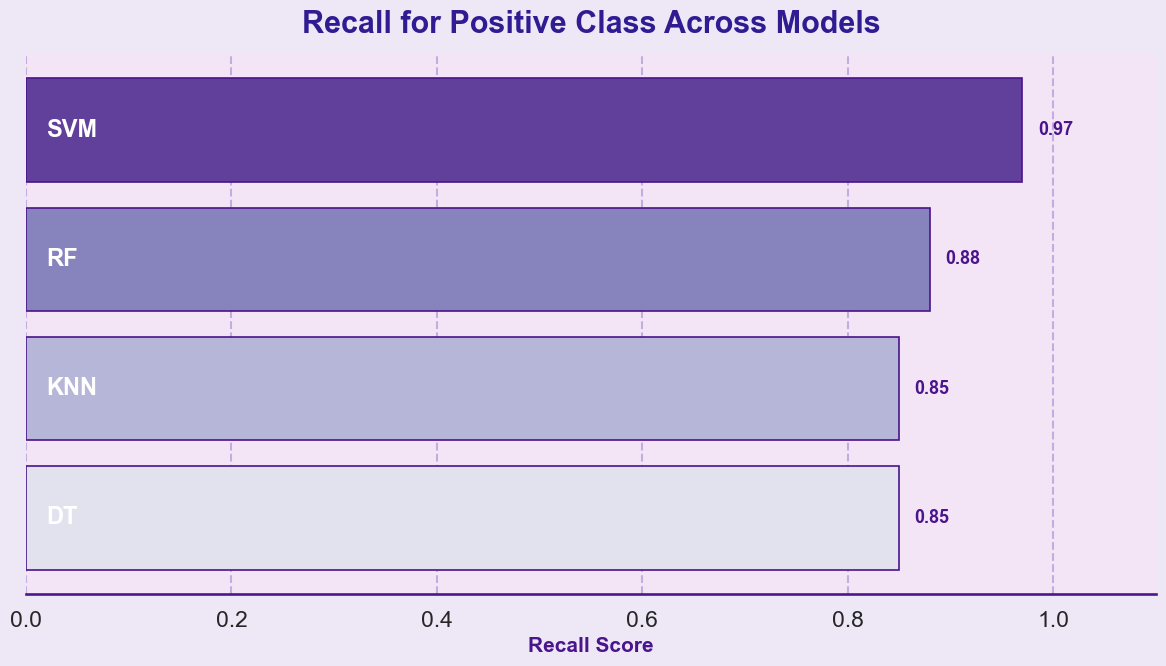

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort values based on 'recall_1'
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']

# Define violet gradient palette
colors = sns.color_palette("Purples", len(recall_1_scores))

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
bars = ax.barh(results.index, recall_1_scores, color=colors, edgecolor='#4a148c', linewidth=1.2)

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    # Value label at the end of each bar
    ax.text(value + 0.015, i, f"{value:.2f}",
            ha='left', va='center',
            fontweight='bold', color='#4a148c', fontsize=13)
    
    # Model name label (bold white)
    ax.text(0.02, i, name,
            ha='left', va='center',
            fontweight='bold', color='white', fontsize=17)

# Styling
ax.set_facecolor('#f3e5f5')  # light violet background
fig.patch.set_facecolor('#ede7f6')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines['bottom'].set_color('#4a148c')
ax.set_yticks([])

# Add gridlines and axis labels
ax.xaxis.grid(True, linestyle='--', alpha=0.4, color='#7e57c2')
ax.set_xlim([0, 1.1])
plt.title("Recall for Positive Class Across Models", fontsize=22, fontweight='bold', color='#311b92', pad=15)
plt.xlabel("Recall Score", fontsize=15, fontweight='bold', color='#4a148c')

plt.tight_layout()
plt.show()
